# **Исследовательский ноутбук. Пономаренко Алексей. AI Masters 2023.**

В данном ноутбуке я буду решать 3 различных кейса.

В каждом кейсе будут подбираться оптимальные индексы и их параметры для построения модели с нужной скоростью и качеством.

## **Первый кейс**

Подробное описание кейса содержится в основном ноутбуке, поэтому здесь я буду только непосредственно делать исследовательскую работу, а также комментировать полученные результаты.

Для начала установим все, что нам будет необходимо для исследования.

In [14]:
# !pip install --upgrade faiss-cpu hnswlib

In [15]:
# !pip install h5py

In [1]:
from utils.utils import plot_ann_performance, analyze_ann_method
from utils.index import *
from functools import partial
import numpy as np


%load_ext autoreload
%autoreload 2

Подгрузим данные

In [2]:
import h5py
from urllib.request import urlretrieve
import os

def get_ann_benchmark_data(dataset_name):
    if not os.path.exists(f"{dataset_name}.hdf5"):
        print(f"Dataset {dataset_name} is not cached; downloading now ...")
        urlretrieve(f"http://ann-benchmarks.com/{dataset_name}.hdf5", f"{dataset_name}.hdf5")
    hdf5_file = h5py.File(f"{dataset_name}.hdf5", "r")
    return np.array(hdf5_file['train']), np.array(hdf5_file['test'])

Посмотрим на размеры скачанного датасета

In [16]:
tr, tst = get_ann_benchmark_data('glove-25-angular')
tr.shape, tst.shape

((1183514, 25), (10000, 25))

Посмотрим на распределение данных

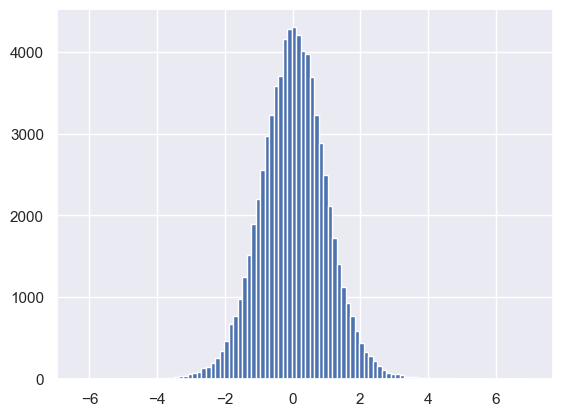

In [17]:
import matplotlib.pyplot as plt

plt.hist(tr[:3000].ravel(), bins=100)
plt.show()

Пока попробуем все индексы

In [18]:
assert tr.shape[1] == tst.shape[1]

In [19]:
tr.shape[1]

25

In [20]:
k_0 = 10
dim = tr.shape[1]

# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_l2(tr, dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

248.2302859929991


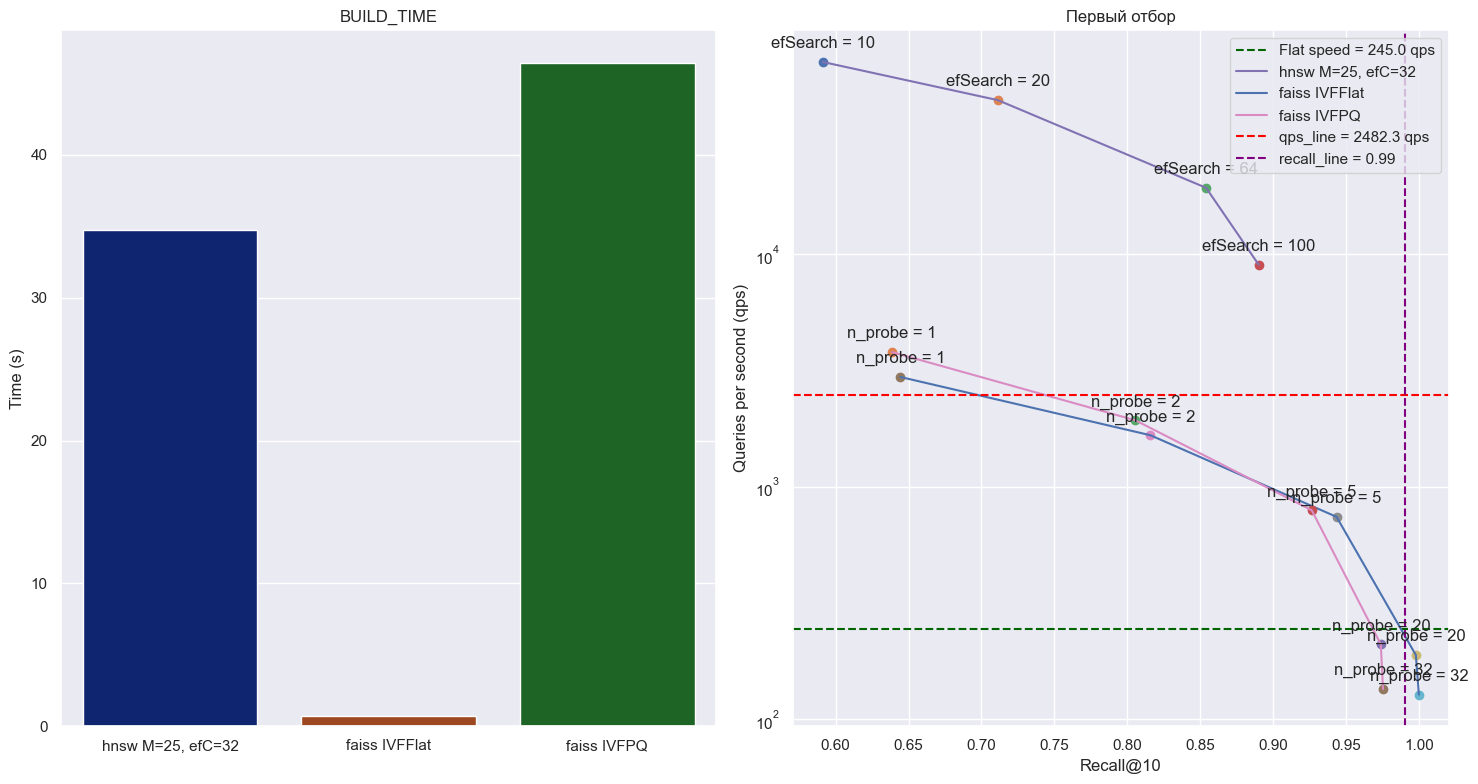

In [21]:
index_dict = {
    'hnsw M=25, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 25, 'ef_construction': 32},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
    'faiss IVFPQ': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 64,
            'm': 25,
            'nbits': 8,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Первый отбор',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Из данного эксперимета можно явно сделать  вывод о том, что индекс faiss IVFPQ нам не подойдет, потому что

1.   Он самый медленный (его линия скорости ниже всех)
2.   У него самая низкая точность (он находится левее всех и даже левее линии recall = 0.99)



Теперь попробуем покрутить параметры для первых двух методов

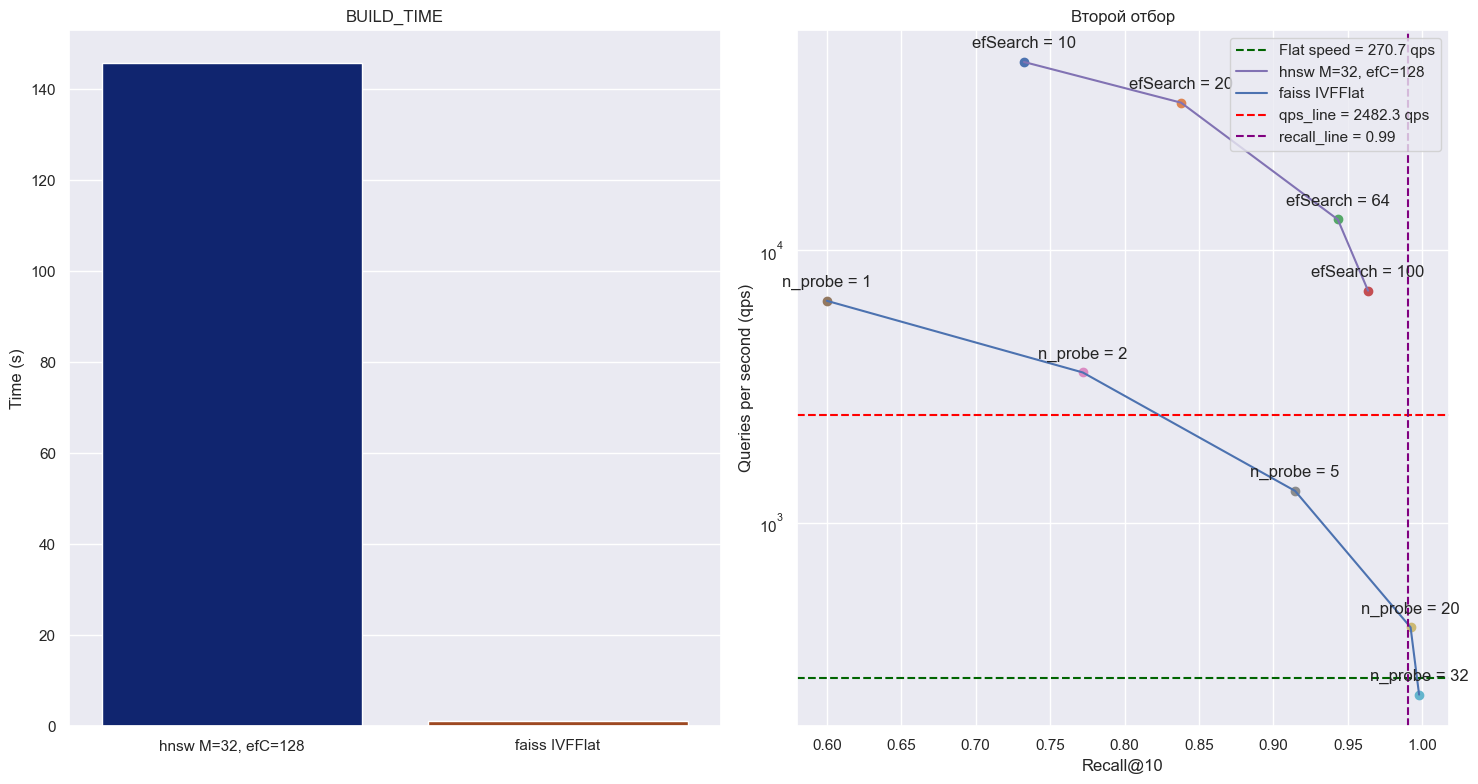

In [22]:
index_dict = {
    'hnsw M=32, efC=128': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 128,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [1, 2, 5, 20, 32]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Второй отбор',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Попробовав немного покрутить различные параметры faiss IVFFlat, я понял, что у него нет перспективы - сильно меньше по скорости. Тогда далее будем просто пробовать исследовать и улучшать hnsw, несмотр на то что у него достаточно большое время на построение.

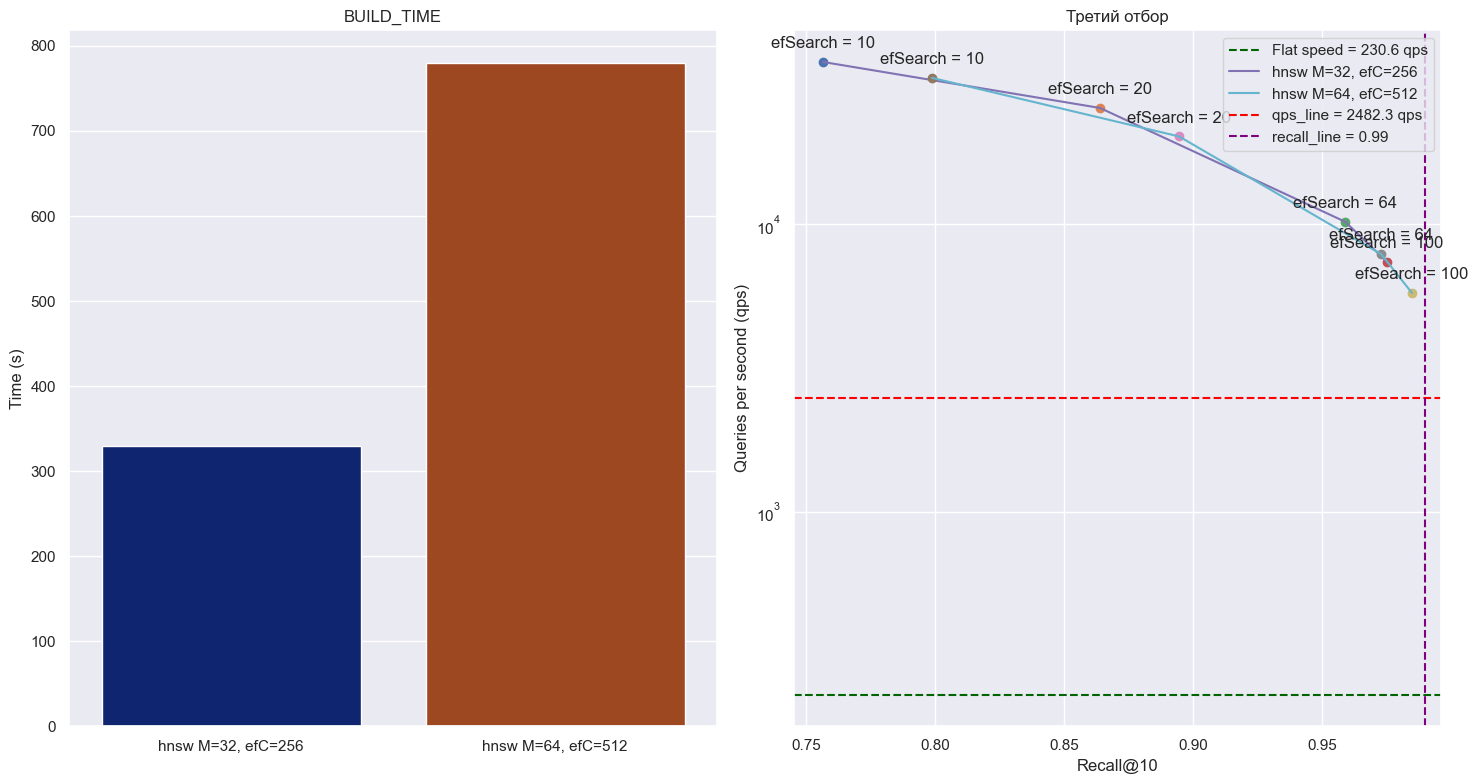

In [23]:
index_dict = {
    'hnsw M=32, efC=256': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 256},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'hnsw M=64, efC=512': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 512},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [10, 20, 64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Третий отбор',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Видим, что при увеличении параметров качество улучшается , а скорость несильно падает. Тогда попробуем еще раз увеличить параметры. Также заметим, что у параметра efSearch маленькие значения не подходят, тогда просто оставим 64 и 100 для пробы.

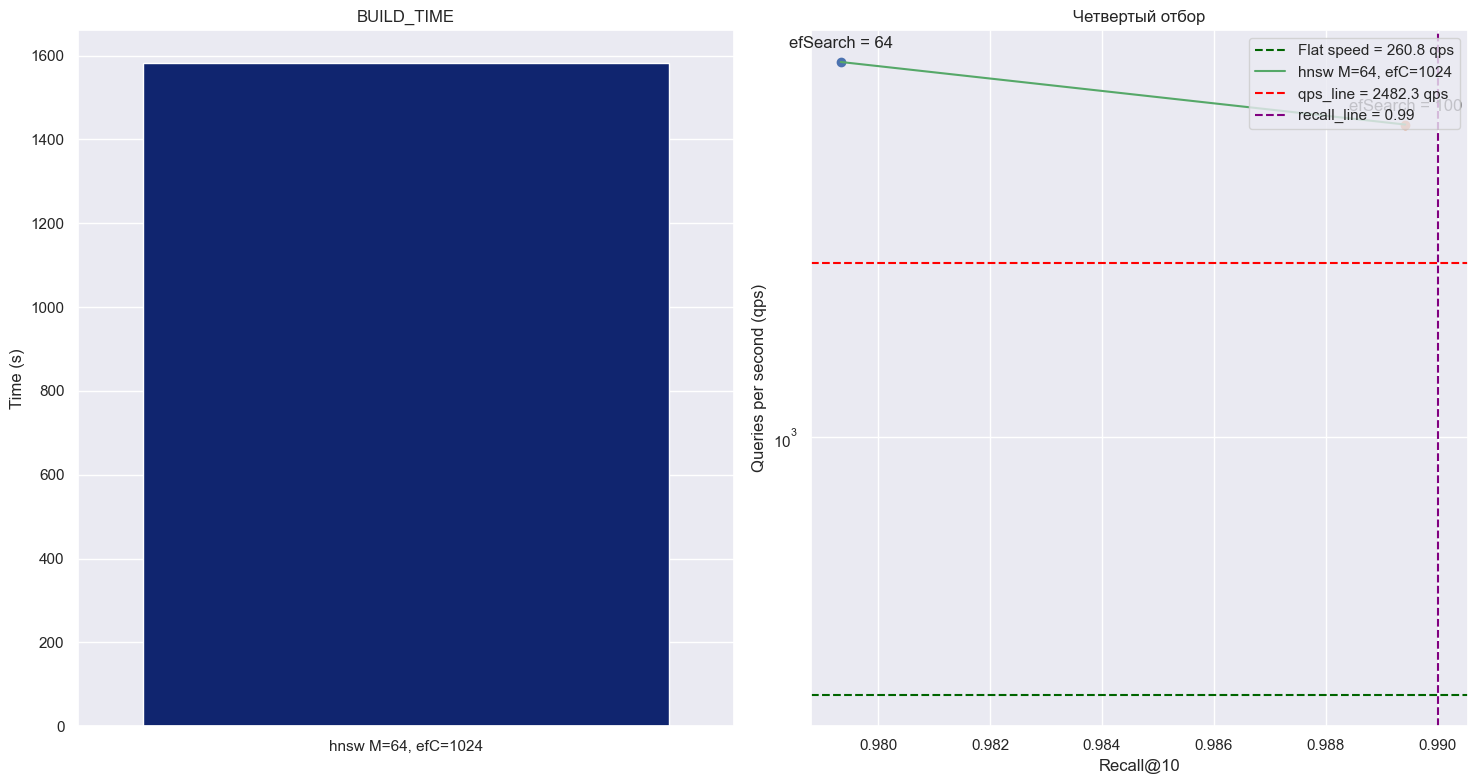

In [24]:
index_dict = {
    'hnsw M=64, efC=1024': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 1024},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [64, 100]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Четвертый отбор',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Обратим внимание, что со скоростью у нас проблем нет. Есть проблемы с качеством и временем. При увеличении параметров M и ef_construction мы все сильнее выходим из временного барьера. Тогда попробуем немного уменьшить эти два параметра и сильно поднять параметр для поиска, например, сделав его равным 256.

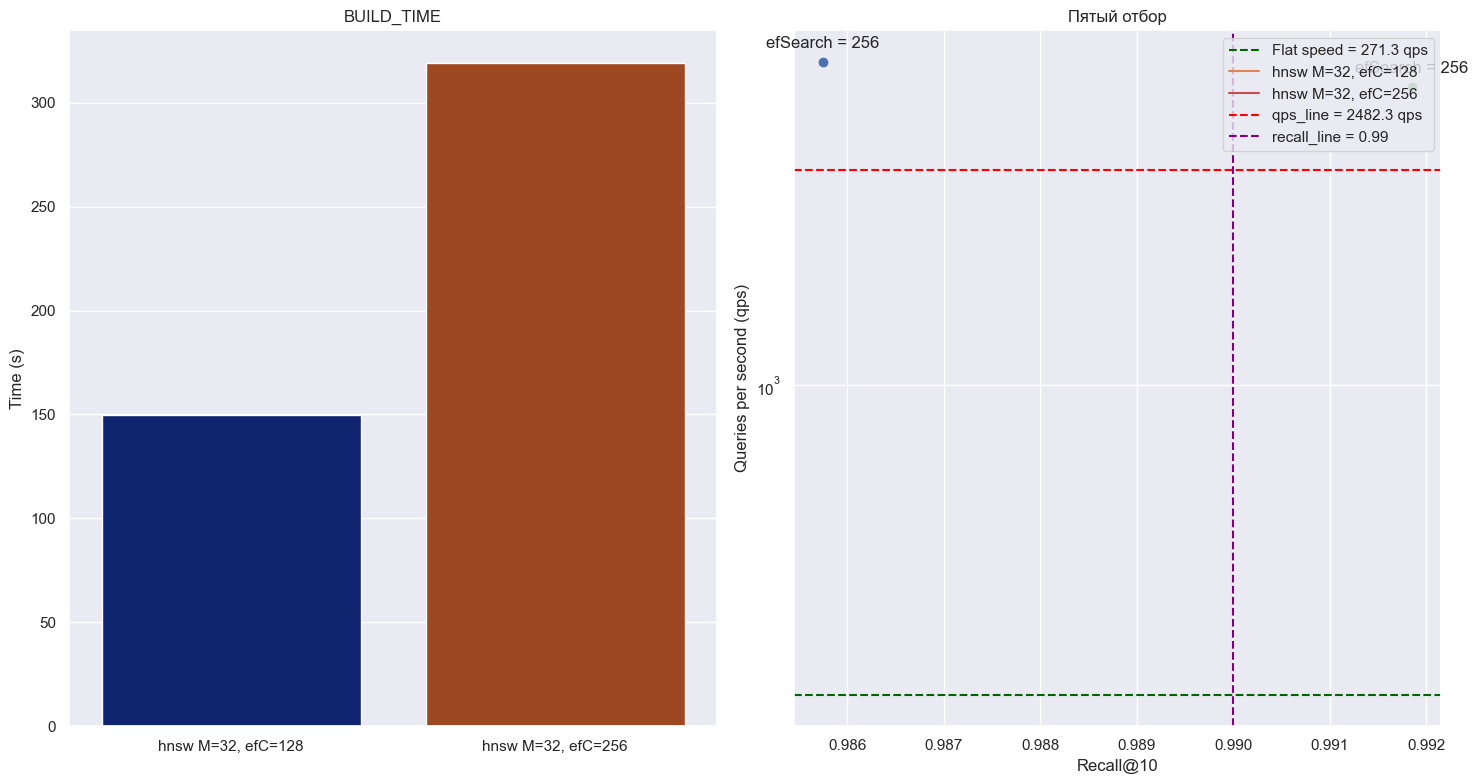

In [25]:
index_dict = {
    'hnsw M=32, efC=128': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [256]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'hnsw M=32, efC=256': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 256},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [256]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Пятый отбор',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Итак, мы получили нужные параметры. Только вот одна проблемка... Я не знаю, какая точка к какому случаю относится :( Ошибка, но ладно. Смею предположить, что это второй случай. Сейчас подставлю уже в основной ноубук и убедюсь. 

## **Второй кейс**

In [3]:
tr, tst = get_ann_benchmark_data('nytimes-256-angular')
tr.shape, tst.shape

((290000, 256), (10000, 256))

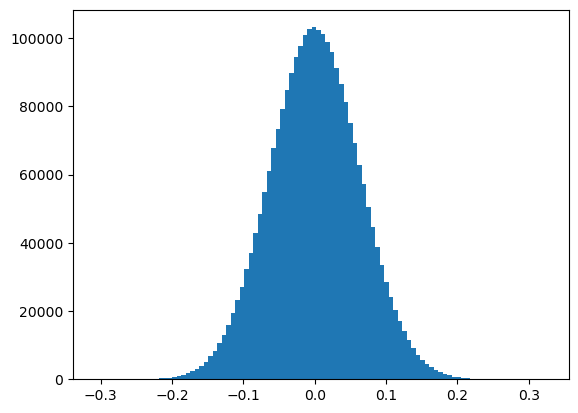

In [4]:
import matplotlib.pyplot as plt

plt.hist(tr[:10000].ravel(), bins=100)
plt.show()

In [5]:
k_0 = 10
dim = tr.shape[1]

### Выборка 20 000.

Евклидова мера.

In [31]:
# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_l2(tr[:20000], dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

9837.422228664322


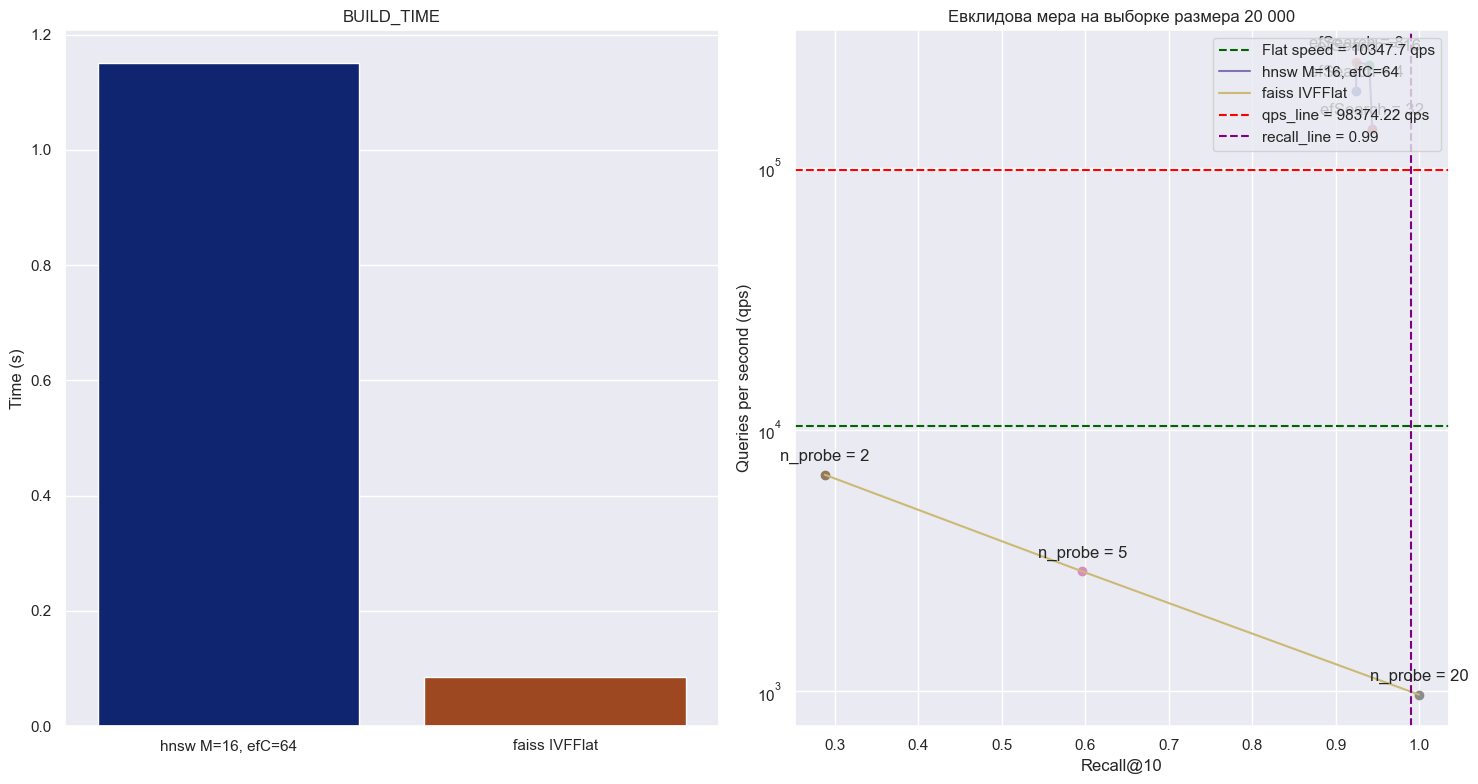

In [43]:
index_dict = {
    'hnsw M=16, efC=64': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 16, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [4, 8, 16, 32]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 16,
            'metric': faiss.METRIC_L2,
            'num_threads': 4
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [2, 5, 20]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr[:20000],
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Евклидова мера на выборке размера 20 000',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Видно, что faiss работает очень медленно, но зато точно. HNSW работает быстро, но недостаточно точно. Посмотрим на ошибки.

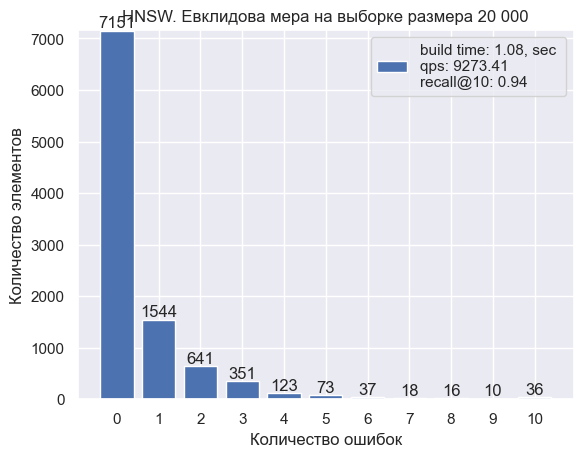

In [49]:
analyze_ann_method(
    build_data = tr[:20000],
    query_data = tst,
    build_func = partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 16, 'ef_construction': 128}),
    search_func = partial(search_hnsw, efSearch = 32),
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'HNSW. Евклидова мера на выборке размера 20 000'
)

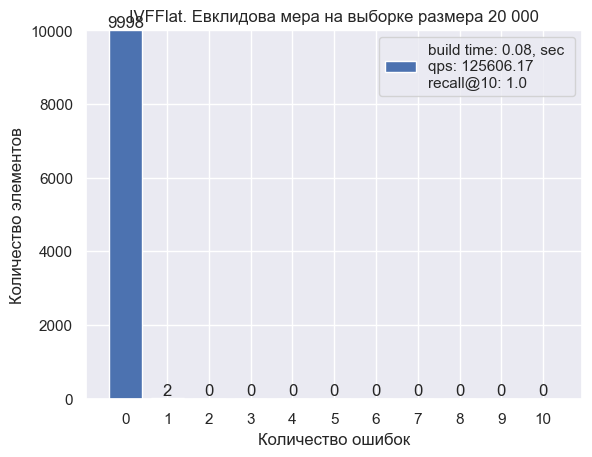

In [50]:
analyze_ann_method(
    build_data = tr[:20000],
    query_data = tst,
    build_func = partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'nlist': 16, 'metric': faiss.METRIC_L2, 'num_threads': 4}),
    search_func = partial(search_faiss, nprobe = 20),
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'IVFFlat. Евклидова мера на выборке размера 20 000'
)

Косинусная мера.

In [6]:
# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_ip(tr[:20000], dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

12879.850513667343


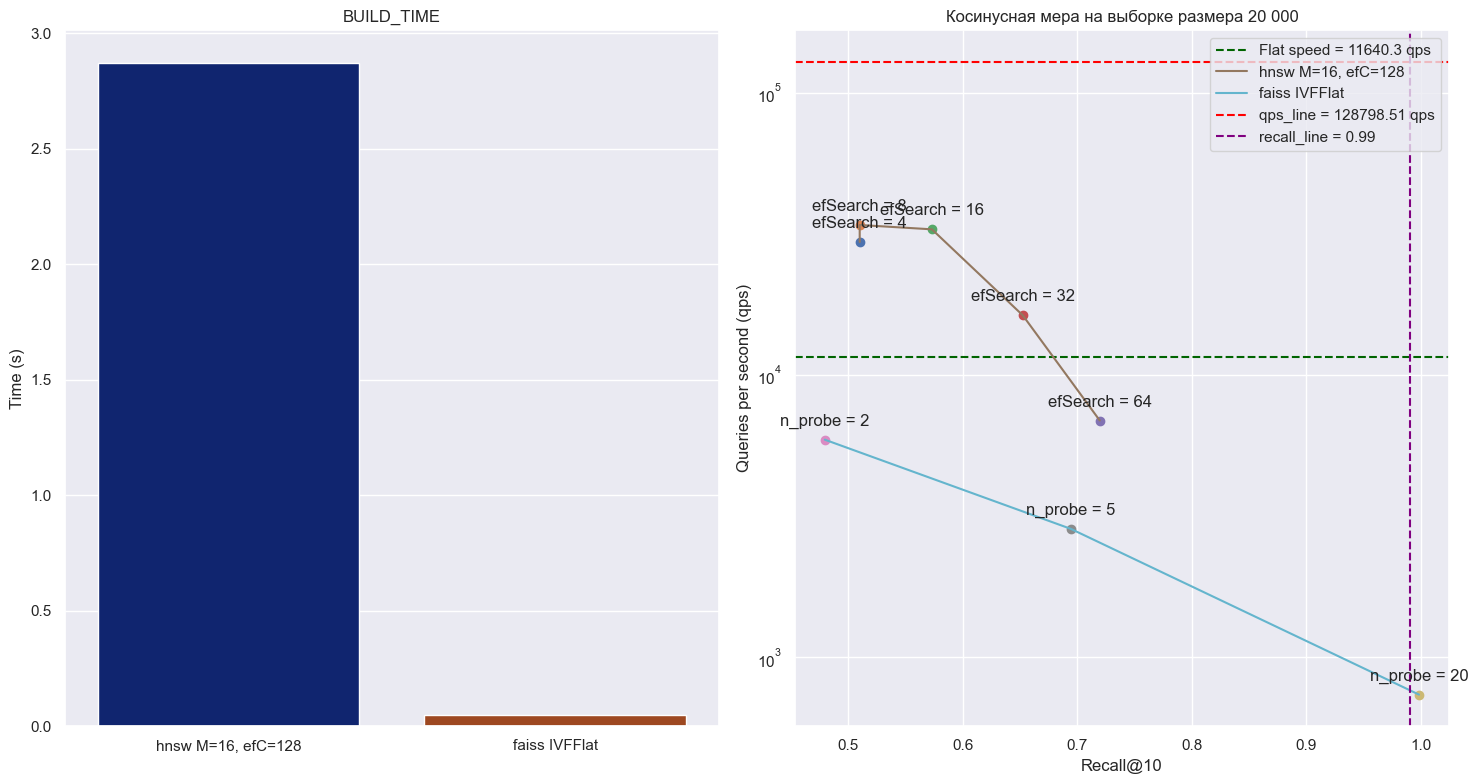

In [9]:
index_dict = {
    'hnsw M=16, efC=128': {
        'fixed_params': {'dim': dim, 'space': 'cosine', 'M': 16, 'ef_construction': 128},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [4, 8, 16, 32, 64]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 16,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 4
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [2, 5, 20]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr[:20000],
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Косинусная мера на выборке размера 20 000',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

Тут опять faiss работает очень точно, но медленно. HNSW работает чуть быстрее, но гораздо хуже.

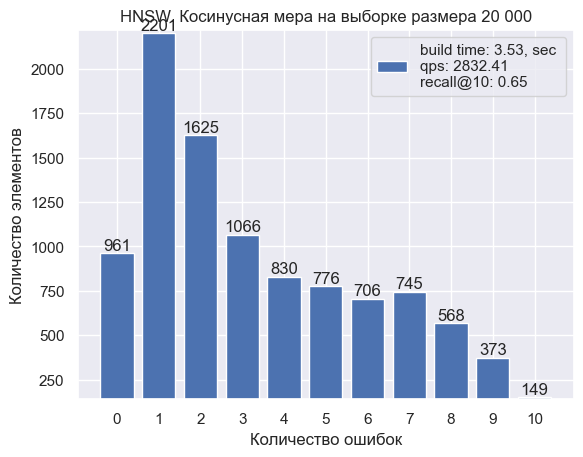

In [10]:
analyze_ann_method(
    build_data = tr[:20000],
    query_data = tst,
    build_func = partial(build_hnsw, **{'dim': dim, 'space': 'cosine', 'M': 16, 'ef_construction': 128}),
    search_func = partial(search_hnsw, efSearch = 32),
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'HNSW. Косинусная мера на выборке размера 20 000'
)

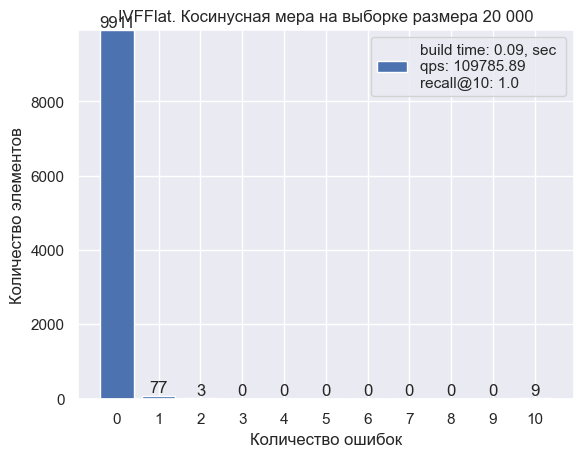

In [11]:
analyze_ann_method(
    build_data = tr[:20000],
    query_data = tst,
    build_func = partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'nlist': 16, 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': 4}),
    search_func = partial(search_faiss, nprobe = 20),
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'IVFFlat. Косинусная мера на выборке размера 20 000'
)

### Выборка 50 000.

Евклидова мера.

In [12]:
# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_l2(tr[:50000], dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

4769.165362177301


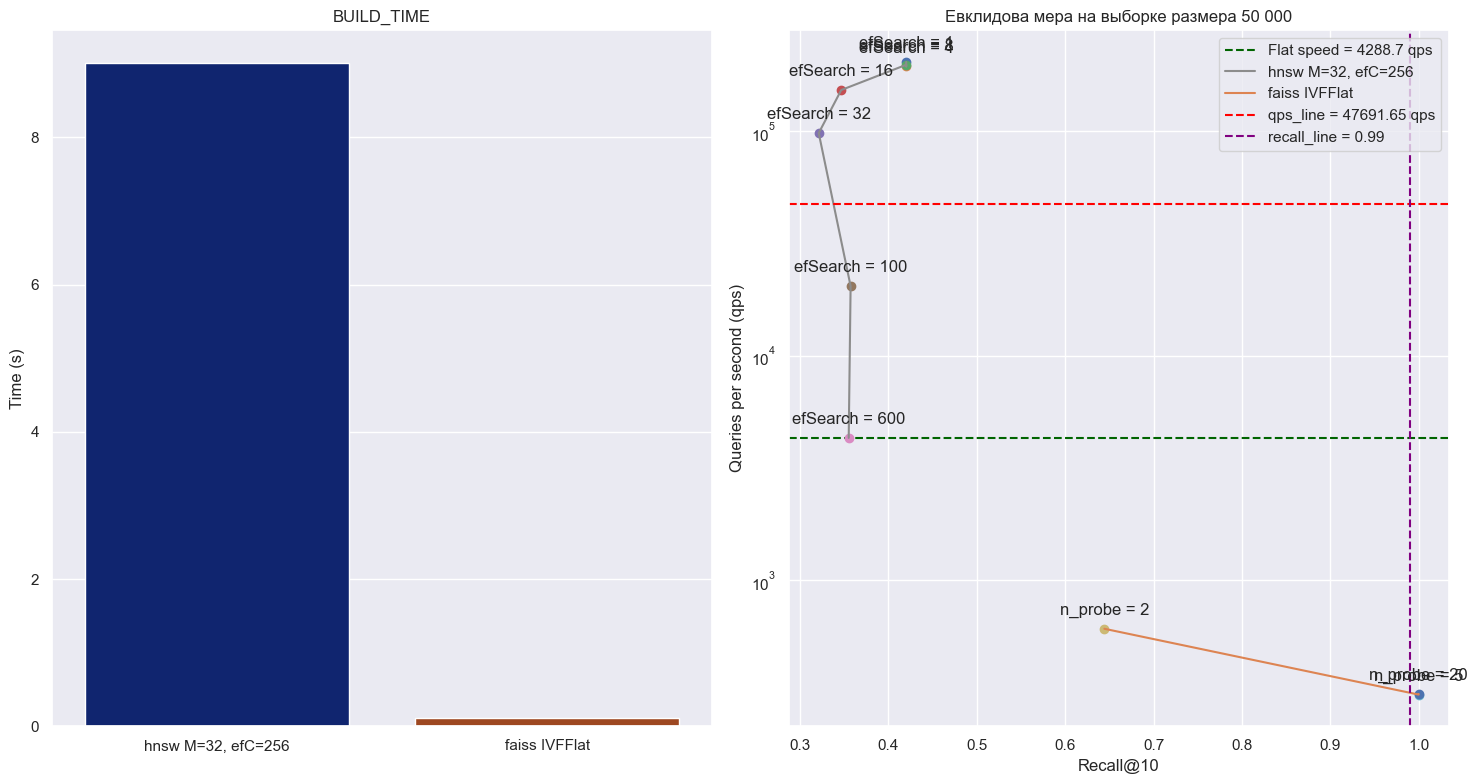

In [13]:
index_dict = {
    'hnsw M=32, efC=256': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 256},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [1, 4, 8, 16, 32, 100, 600]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 4,
            'metric': faiss.METRIC_L2,
            'num_threads': 4
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [2, 5, 20]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr[:50000],
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Евклидова мера на выборке размера 50 000',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

В данном случае опять же видно, что faiss работает очень медленно, но зато точно. HNSW работает быстро, но очень не точно. Посмотрим на ошибки.

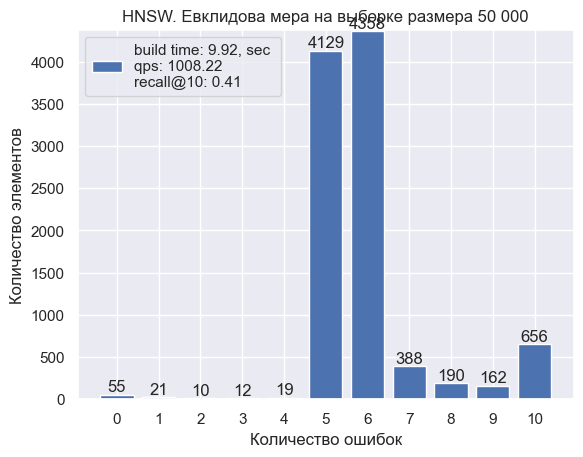

In [14]:
analyze_ann_method(
    build_data = tr[:50000],
    query_data = tst,
    build_func = partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 256}),
    search_func = partial(search_hnsw, efSearch = 1),
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'HNSW. Евклидова мера на выборке размера 50 000'
)

Если честно, я вооообще не понимаю, почему такая плохая точность. Я попробовал поперебирать разные параметры и все равно качество очень плохое.

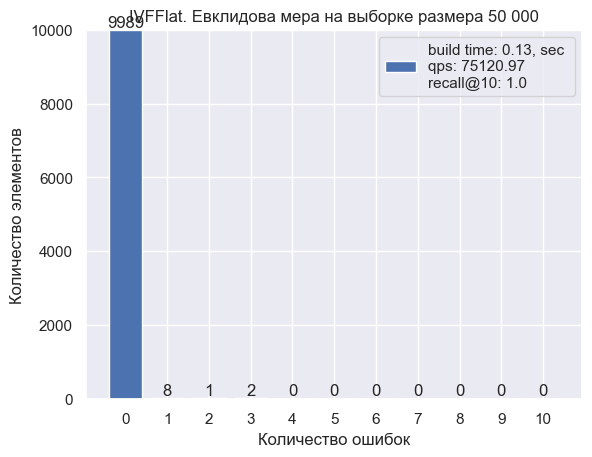

In [15]:
analyze_ann_method(
    build_data = tr[:50000],
    query_data = tst,
    build_func = partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'nlist': 4, 'metric': faiss.METRIC_L2, 'num_threads': 4}),
    search_func = partial(search_faiss, nprobe = 20),
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'IVFFlat. Евклидова мера на выборке размера 50 000'
)

Косинусная мера.

In [16]:
# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_ip(tr[:50000], dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

5223.529435207274


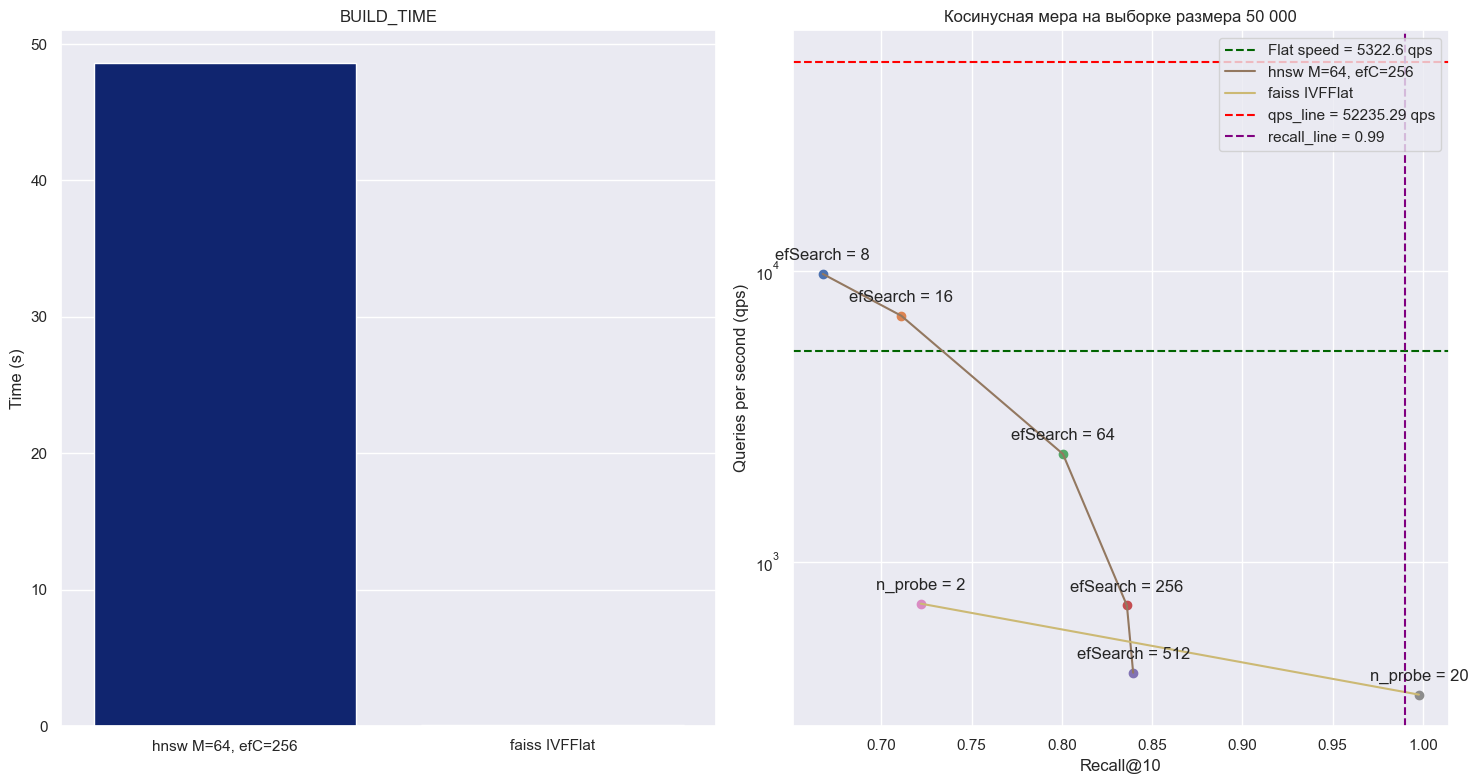

In [19]:
index_dict = {
    'hnsw M=64, efC=256': {
        'fixed_params': {'dim': dim, 'space': 'cosine', 'M': 64, 'ef_construction': 256},
        'build_func': build_hnsw, # ест build_data и fixed_params, возвращает построенный индекс
        'search_param': ('efSearch', [8, 16, 64, 256, 512]), # (имя параметра поиска, [используемые значения])
        'search_func': search_hnsw # ест index, query_data, k_neighbors, search_param, возвращает distances, labels
    },
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 4,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 8
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [2, 20]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr[:50000],
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Косинусная мера на выборке размера 50 000',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

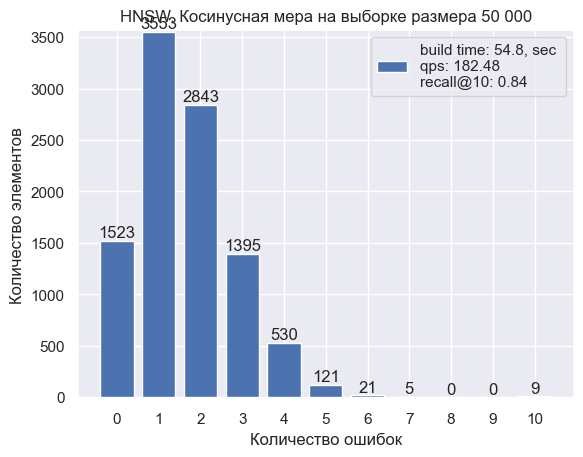

In [20]:
analyze_ann_method(
    build_data = tr[:50000],
    query_data = tst,
    build_func = partial(build_hnsw, **{'dim': dim, 'space': 'cosine', 'M': 64, 'ef_construction': 256}),
    search_func = partial(search_hnsw, efSearch = 256),
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'HNSW. Косинусная мера на выборке размера 50 000'
)

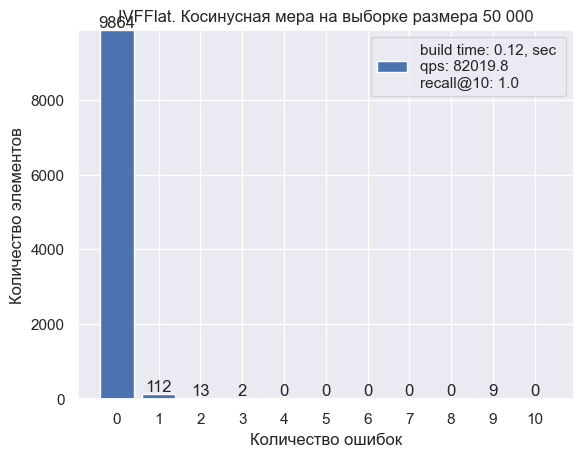

In [21]:
analyze_ann_method(
    build_data = tr[:50000],
    query_data = tst,
    build_func = partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'nlist': 4, 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': 8}),
    search_func = partial(search_faiss, nprobe = 20),
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'IVFFlat. Косинусная мера на выборке размера 50 000'
)

### Полная выборка.

Как можно заметить из предыдущих экспериментов, HNSW работает не очень, поэтому в последнем эксперименте вообще не будем тратить на него время.

Евклидова мера.

In [23]:
# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_l2(tr, dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

697.3146669375922


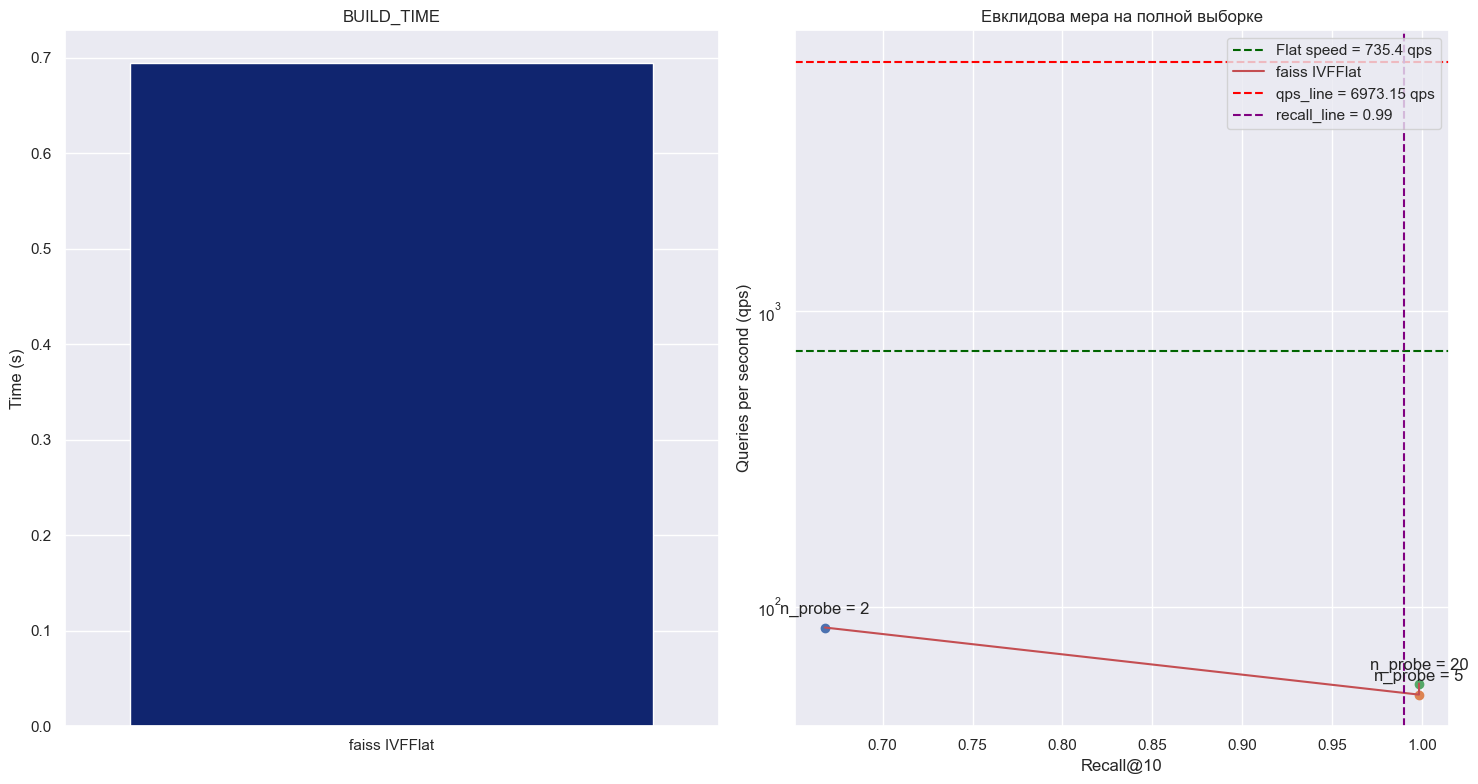

In [24]:
index_dict = {
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 4,
            'metric': faiss.METRIC_L2,
            'num_threads': 8
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [2, 5, 20]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Евклидова мера на полной выборке',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

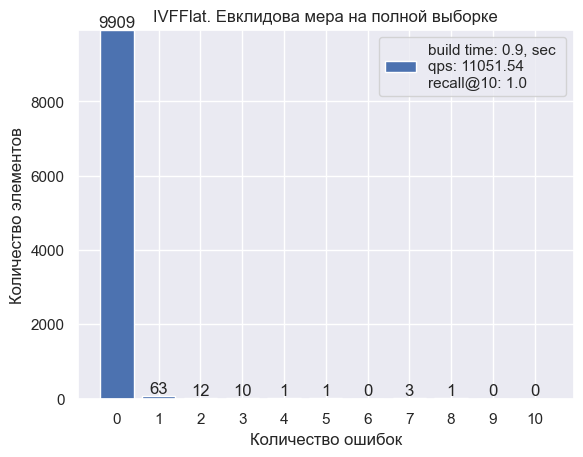

In [25]:
analyze_ann_method(
    build_data = tr,
    query_data = tst,
    build_func = partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim), 'nlist': 4, 'metric': faiss.METRIC_L2, 'num_threads': 4}),
    search_func = partial(search_faiss, nprobe = 20),
    k = k_0,
    flat_build_func = partial(build_flat_l2, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'IVFFlat. Евклидова мера на полной выборке'
)

Косинусная мера.

In [26]:
# Посчитаем примерную границу для скорости (примерную потому что эта скорость будет ...
# ... еще раз пересчитываться внутри самой ф-и plot_ann_performance, но я буду считать ...
# ... это небольшой погрешностью в визуальных данных
flat_index, flat_build_time = build_flat_ip(tr, dim)
flat_distances, flat_labels, flat_search_time = search_flat(flat_index, tst, k_0)
flat_speed = tst.shape[0] / flat_search_time

print(flat_speed)

914.6548244970248


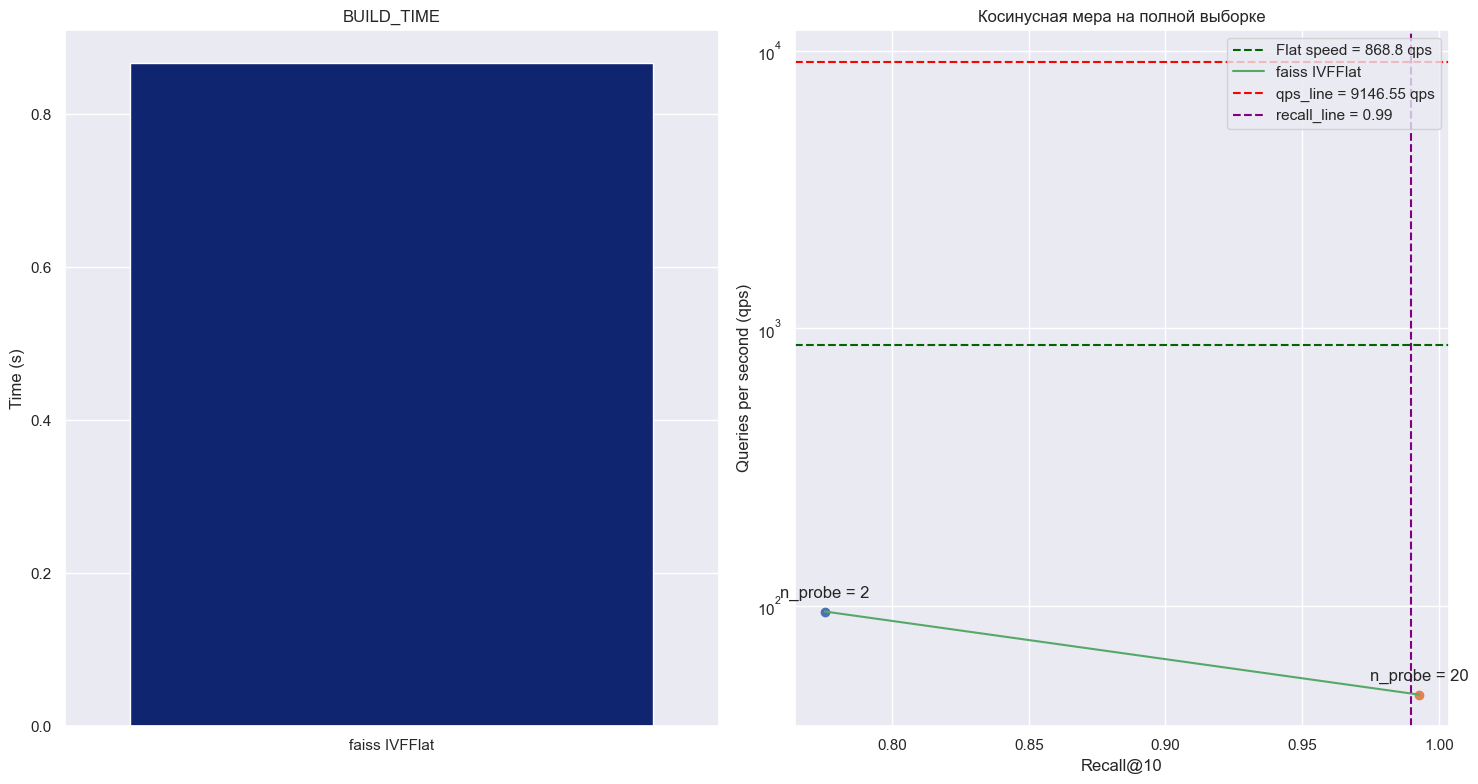

In [27]:
index_dict = {
    'faiss IVFFlat': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatIP(dim),
            'nlist': 4,
            'metric': faiss.METRIC_INNER_PRODUCT,
            'num_threads': 8
        },
        'build_func': build_IVFFlat,
        'search_param': ('n_probe', [2, 20]),
        'search_func': search_faiss
    },
}

# Построим график
plot_ann_performance(
    build_data = tr,
    query_data = tst,
    index_dict = index_dict,
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim = dim),
    flat_search_func = search_flat,
    query_in_train = False,
    title = 'Косинусная мера на полной выборке',
    qps_line = 10 * flat_speed,
    recall_line = 0.99
)

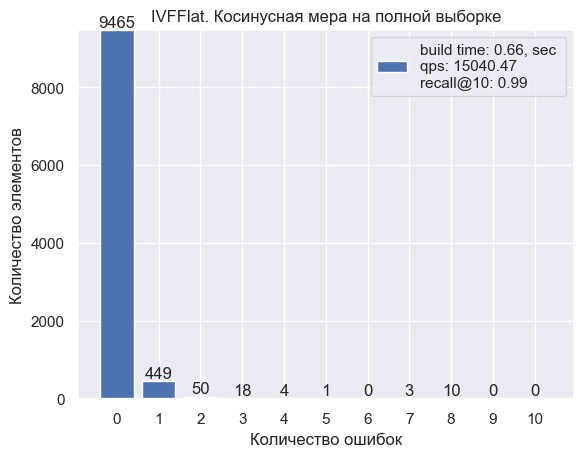

In [28]:
analyze_ann_method(
    build_data = tr,
    query_data = tst,
    build_func = partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatIP(dim), 'nlist': 4, 'metric': faiss.METRIC_INNER_PRODUCT, 'num_threads': 8}),
    search_func = partial(search_faiss, nprobe = 20),
    k = k_0,
    flat_build_func = partial(build_flat_ip, dim=dim),
    flat_search_func = search_flat,
    query_in_train = False,
    index_name = 'IVFFlat. Косинусная мера на полной выборке'
)

Таким образом, можно сделать вывод, что HNSW не подходит для датасетов с большой размерностью векторов, а faiss справляется с высокой точностью, но с низкой скоростью. Также можно обратить внимание на то, что при использовании евклидовой меры количество ошибок в среднем меньше, чем при использовании косинусной. HNSW становится непригодной в высокоразмерных пространствах в связи с тем, что теряется структура графа, и точки, которые должны были быть рядом, оказываются далеко, а также неадекватно оценивается плотность данных.

Очень хочется продолжить писать этот ноутбук и доделать третий кейс и крабов, но я уже очень устал, убив на всю уже проделанную работу полных 2 суток и еще 1 вечер. Я очень старался и надеюсь, что мой труд будет оценен по достоинству.